In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")

print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [08:30<00:00, 23.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


In [3]:
!ls /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1/

Test  Train


In [4]:
train_dir = "/root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1/Train"
test_dir = "/root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [5]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [6]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 1266345 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


In [7]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [8]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [9]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(LR),
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,095,054 (30.88 MB)

 Trainable params: 8,011,406 (30.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [10]:
history = model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

19787/19787 ━━━━━━━━━━━━━━━━━━━━ 2310s 111ms/step - auc: 0.8692 - loss: 1.5065 - val_auc: 0.8400 - val_loss: 1.6937


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step
ROC AUC score: 0.8403457676698056


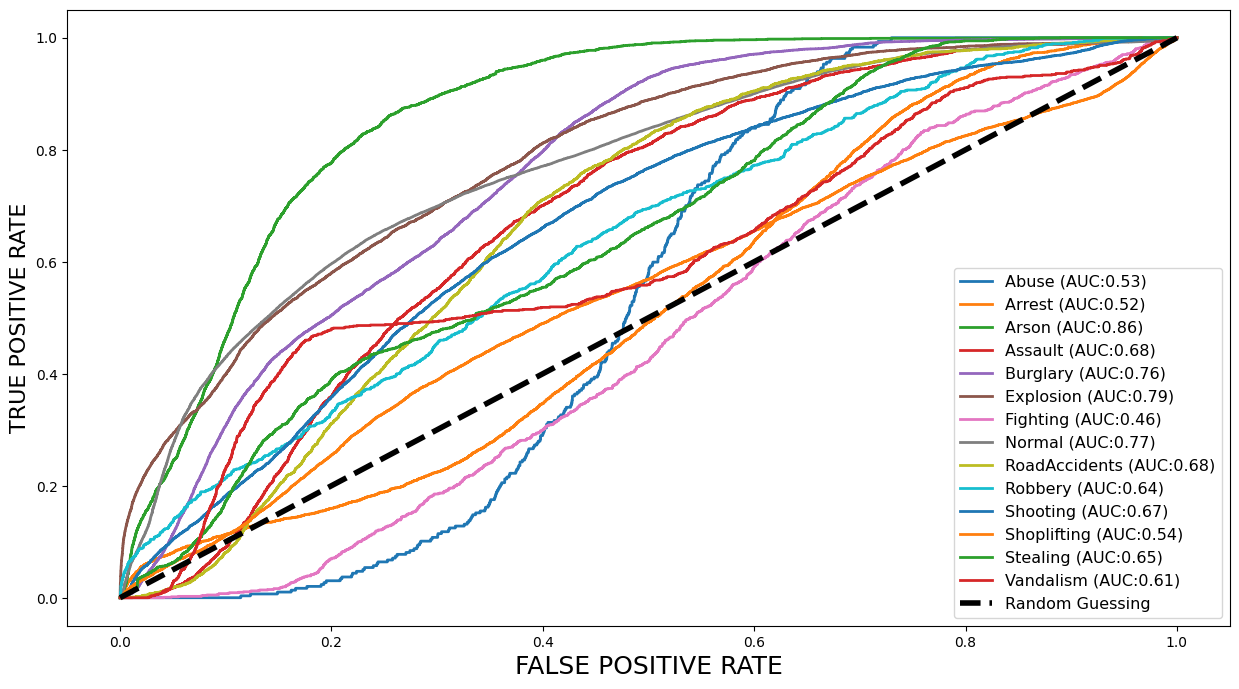

In [11]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [13]:
# Save model
MODEL_PATH = "/content/ucf_crime_densenet"
model.save("/content/ucf_crime_densenet.h5")

print("✅ Model saved at:", MODEL_PATH)


✅ Model saved at: /content/ucf_crime_densenet
